# English level (model training)

## Intro

**Yandex.Practicum's English department** is a customer for this project https://practicum.yandex.ru/english/

One of the most effective ways to study foreighn languages (including English) is to watch movies. It's considered it's best for the student to watch videos in which they can understand from 50% to 70% of all dialogs in order to maximise their learning rate. Thus it's vital how movie contents matches an English level. We will use **CEFR** to define English level.

A dataset containig information on some movies' English level is provided by Yandex.Prackticum experts.

**Objective** is to build a model that can evaluate English level of movies based on their subtitles content.

This project is devided on three notebooks:
* `english_level_dataset.ipynb`: forms a dataset from all the data and saves it into `text_labels.csv` file
* `english_level_modeling.ipynb`: takes `text_labels.csv` file, does text processing, modeling and saves model `english_labels_model.pkl` file
* `english_level_servise.ipynb`: allows to label provided `.srt` file using the saved model

We will use `.csv` file that contains:
* labels
* raw text data without timestamos
* full text data with timestamps

In this notebook we will use several approaches to preprocess data, train model and compare them

In [1]:
# libraries to work with data
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# libraries to work with files
import joblib

from pathlib import Path

In [3]:
# natural language toolkit
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [35]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.pipeline import Pipeline

In [5]:
# optuna
import optuna

from optuna.samplers import TPESampler
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

In [12]:
# global variables
PATH_TRAIN_DATA = r'./text_labels.csv'
RND_STATE = 1337

In [13]:
# regex for text processing
HTML = re.compile(r'<.*?>')
TAG = re.compile(r'{.*?}')
COMMENTS = re.compile(r'[\(\[][A-Z ]+[\)\]]')
LETTERS = re.compile(r'[^a-zA-Z\'.,!? ]')
SPACES = re.compile(r'([ ])\1+')
DOTS = re.compile(r'[\.]+')

ONLY_WORDS = re.compile(r'[.,!?]|(?:\'[a-z]*)') # for BOW

## Bag of words approach

We will use **Bag of words** approach and **NLTK** library to process text. We won't need timestamps for this

### Text preprocessing

Let's open our train dataset and preprocess data:
* clean text using RE
* tokenize text
* remove stopwords
* lemmatise

In [14]:
# open dataframe
df1 = pd.read_csv(PATH_TRAIN_DATA)
df1 = df1.drop(columns=['full_subs'])
df1.head()

,label,raw_text
0,B1,"<font color=""#ffff80""><b>Fixed & Synced by boz..."
1,B1,"Hey!\nI'll be right with you.\nSo, Cameron. He..."
2,B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...
3,B2,"- <i><font color=""#ffffff""> Synced and correct..."
4,A2,"<i>Oh, I come from a land\nFrom a faraway plac..."


In [15]:
# defining stop words list and creating a lemmatiser object
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [16]:
# re text cleaner
def re_clean_subs(subs):
    txt = re.sub(HTML, ' ', subs) # html to space
    txt = re.sub(TAG, ' ', txt) # tags to space
    txt = re.sub(COMMENTS, ' ', txt) # commentaries to space
    txt = re.sub(LETTERS, ' ', txt) # non-char to space
    txt = re.sub(SPACES, r'\1', txt) # leading spaces to one space
    txt = re.sub(DOTS, r'.', txt)  # ellipsis to dot
    txt = txt.encode('ascii', 'ignore').decode() # clear non-ascii symbols   
    txt = ".".join(txt.lower().split('.')[1:-1]) # delete the first and the last subtitle (ads)
    return txt

In [17]:
# this function executes text preprocessing
def text_preprocess_lem(text):
    text = re_clean_subs(text) # clean text using RE
    tokens = nltk.word_tokenize(text) # tokenisation
    text = [word for word in tokens if word not in stop_words] # stop words removal
    text = [lemmatizer.lemmatize(word) for word in text] # lemmatising tokens
    text = " ".join(text) # making text from the list
    return text

In [18]:
# apply text preprocessing
df1['preprocessed_text'] = df1['raw_text'].apply(text_preprocess_lem)
df1

,label,raw_text,preprocessed_text
0,B1,"<font color=""#ffff80""><b>Fixed & Synced by boz...","enjoy flick ben phone michelle , please n't ha..."
1,B1,"Hey!\nI'll be right with you.\nSo, Cameron. He...",", cameron . go . nine school year . , . army b..."
2,B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...,two minute forfeit . lend u . right . left . d...
3,B2,"- <i><font color=""#ffffff""> Synced and correct...",black eye open wide 's time testify room lie e...
4,A2,"<i>Oh, I come from a land\nFrom a faraway plac...","please , please , come closer . close . little..."
...,...,...,...
268,C1,I lost Ava her company.\nI assume my deal\nwit...,assume deal edward dead . long win murder tria...
269,C1,Previously on\n<i>Suits...</i>\nIt's going up\...,'s going wall tomorrow . way getting side . n'...
270,C1,"I get Ava Hessington acquitted,\nDarby backs m...",n't want anymore . get sight . called mariga o...
271,C1,Previously on\n<i>Suits...</i>\nI'm bonding\nw...,"'m bonding father . speaking 're taking easy ,..."


### Vectorising text

In order for ML model to work with text we need to vectorise it first. Let's start with simple **bag of words** method. Since this method is sensitive only to words we will get rid of symbols

In [19]:
# leaving only words
df1['bow_text'] = df1['preprocessed_text'].apply(lambda x: re.sub(ONLY_WORDS, '', x))
df1['bow_text'] = df1['bow_text'].apply(lambda x: re.sub(r'\s+', ' ', x)) # removing multiple spaces
display(df1.head())

,label,raw_text,preprocessed_text,bow_text
0,B1,"<font color=""#ffff80""><b>Fixed & Synced by boz...","enjoy flick ben phone michelle , please n't ha...",enjoy flick ben phone michelle please n hang t...
1,B1,"Hey!\nI'll be right with you.\nSo, Cameron. He...",", cameron . go . nine school year . , . army b...",cameron go nine school year army brat yeah da...
2,B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...,two minute forfeit . lend u . right . left . d...,two minute forfeit lend u right left dead eh t...
3,B2,"- <i><font color=""#ffffff""> Synced and correct...",black eye open wide 's time testify room lie e...,black eye open wide time testify room lie ever...
4,A2,"<i>Oh, I come from a land\nFrom a faraway plac...","please , please , come closer . close . little...",please please come closer close little close w...


Now we split our data to train and test samples

In [20]:
# features and targets
X1 = df1['bow_text'].copy()
y1 = df1['label'].copy()

# splitting
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, stratify=y1, random_state=RND_STATE)

for data in (X1_train, X1_test, y1_train, y1_test):
    print(data.shape)

(204,)
(69,)
(204,)
(69,)


In [21]:
# creating a vectoriser object and vectorising texts in samples
vectorizer_bow = CountVectorizer()
vectorizer_bow.fit(X1_train)

X1_train = vectorizer_bow.transform(X1_train)
X1_test = vectorizer_bow.transform(X1_test)

display(X1_train, X1_test)

<204x25650 sparse matrix of type '<class 'numpy.int64'>'
	with 224760 stored elements in Compressed Sparse Row format>

<69x25650 sparse matrix of type '<class 'numpy.int64'>'
	with 70672 stored elements in Compressed Sparse Row format>

In [22]:
# this function forms a small report
def report(y_test, y_pred):
    print('Subset accuracy is:', accuracy_score(y_test, y_pred))
    print('Confusion matrix:')
    sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['A2', 'B1', 'B2', 'C1']),
                             index=['true A2', 'true B1', 'true B2', 'true C1'],
                             columns=['false A2', 'false B1', 'false B2', 'false C1']),
                annot=True)
    plt.show()
    print(classification_report(y_test, y_pred))

## Model trainig

### Naive Bayes classifier

In [23]:
# trainig naive bayes classifier
model_nb = MultinomialNB()
model_nb.fit(X1_train, y1_train)

MultinomialNB()

Subset accuracy is: 0.6811594202898551
Confusion matrix:


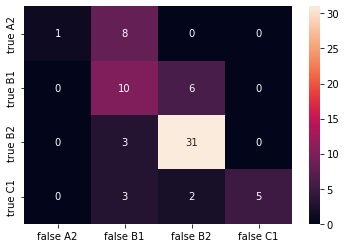

              precision    recall  f1-score   support

          A2       1.00      0.11      0.20         9
          B1       0.42      0.62      0.50        16
          B2       0.79      0.91      0.85        34
          C1       1.00      0.50      0.67        10

    accuracy                           0.68        69
   macro avg       0.80      0.54      0.55        69
weighted avg       0.76      0.68      0.66        69



In [24]:
# prediction and scoring
y1_pred_nb = model_nb.predict(X1_test)
report(y1_test, y1_pred_nb)

### Random Forest classifier

In [25]:
# trainig random forest classifier using optuna
model_rf = RandomForestClassifier(random_state=RND_STATE)
params_rf = {
    'n_estimators': IntDistribution(50, 200),
    'max_depth': IntDistribution(2, 15),
    'min_samples_split': CategoricalDistribution([2, 3]),
    'min_samples_leaf': CategoricalDistribution([1, 2, 3]),
    'bootstrap': CategoricalDistribution([True, False]),
    'class_weight': CategoricalDistribution(['balanced', 'balanced_subsample', None])
}
optuna_rf = OptunaSearchCV(
    model_rf,
    params_rf,
    scoring='accuracy',
    cv=3,
    verbose=1
)

optuna_rf.fit(X1_train, y1_train)

C:\Users\irona\AppData\Local\Temp/ipykernel_17864/1599261084.py:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_rf = OptunaSearchCV(
[I 2023-04-15 18:56:54,394] A new study created in memory with name: no-name-ce9f2014-53ce-4a2a-8a52-8fce7a3d17dc
[I 2023-04-15 18:56:54,395] Searching the best hyperparameters using 204 samples...
[I 2023-04-15 18:56:55,382] Trial 0 finished with value: 0.5588235294117647 and parameters: {'n_estimators': 145, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.5588235294117647.
[I 2023-04-15 18:56:56,340] Trial 1 finished with value: 0.5735294117647058 and parameters: {'n_estimators': 148, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'class_weight': None}. Best is trial 1 with value: 0.5735294117647058.
[I 2023-04-15 18:56:57,227] Trial 2 finished with

OptunaSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1337),
               param_distributions={'bootstrap': CategoricalDistribution(choices=(True, False)),
                                    'class_weight': CategoricalDistribution(choices=('balanced', 'balanced_subsample', None)),
                                    'max_depth': IntDistribution(high=15, log=False, low=2, step=1),
                                    'min_samples_leaf': CategoricalDistribution(choices=(1, 2, 3)),
                                    'min_samples_split': CategoricalDistribution(choices=(2, 3)),
                                    'n_estimators': IntDistribution(high=200, log=False, low=50, step=1)},
               scoring='accuracy', verbose=1)

Subset accuracy is: 0.6086956521739131
Confusion matrix:


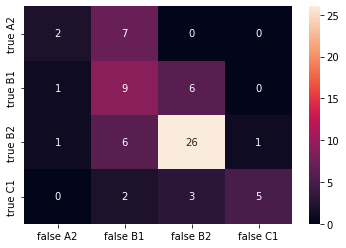

              precision    recall  f1-score   support

          A2       0.50      0.22      0.31         9
          B1       0.38      0.56      0.45        16
          B2       0.74      0.76      0.75        34
          C1       0.83      0.50      0.62        10

    accuracy                           0.61        69
   macro avg       0.61      0.51      0.53        69
weighted avg       0.64      0.61      0.61        69



In [26]:
y1_pred_rf = optuna_rf.best_estimator_.predict(X1_test)
report(y1_test, y1_pred_rf)

### Logistic Regression

In [27]:
# training logistic regression
model_lr = LogisticRegression(max_iter=1000, solver='newton-cg', random_state=RND_STATE)
params_lr = {
    'multi_class': ['ovr', 'multinomial'],
    'class_weight': ['balanced', None]
}

grid_lr = GridSearchCV(
    estimator=model_lr,
    param_grid=params_lr,
    scoring='accuracy',
    cv=5,
    verbose=1
)

grid_lr.fit(X1_train, y1_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=1337,
                                          solver='newton-cg'),
             param_grid={'class_weight': ['balanced', None],
                         'multi_class': ['ovr', 'multinomial']},
             scoring='accuracy', verbose=1)

In [28]:
grid_lr.best_params_

{'class_weight': None, 'multi_class': 'multinomial'}

Subset accuracy is: 0.6811594202898551
Confusion matrix:


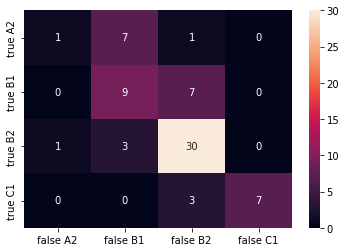

              precision    recall  f1-score   support

          A2       0.50      0.11      0.18         9
          B1       0.47      0.56      0.51        16
          B2       0.73      0.88      0.80        34
          C1       1.00      0.70      0.82        10

    accuracy                           0.68        69
   macro avg       0.68      0.56      0.58        69
weighted avg       0.68      0.68      0.66        69



In [29]:
y1_pred_lr = grid_lr.best_estimator_.predict(X1_test)
report(y1_test, y1_pred_lr)

### Saving file

Naive Bayes classifier and Logistic Regression showed the same score. We will keep it easy and use LogRes model as a file. We also need to save our fitted text vectorizer in order to process new text correctly.

We will pickle the fitted vectorizer and the fitted model and form a pipeline

In [37]:
# creating a pipeline

english_level_pipeline = Pipeline(
    [('Vectorizer', vectorizer_bow),
     ('LogResEstimator', grid_lr.best_estimator_)]
)

english_level_pipeline

Pipeline(steps=[('Vectorizer', CountVectorizer()),
                ('LogResEstimator',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=1337, solver='newton-cg'))])

In [38]:
joblib.dump(english_level_pipeline, 'english_level_model.pkl')

['english_level_model.pkl']

## Conclusion

I tried only **Bag of Words** method of text preprocessing so far and chose LogisticRegression as the best estimator. This estimator is saved in `english_level_model.pkl` file